In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from celluloid import Camera
from collections import deque
from matplotlib import animation

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

# %matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

In [3]:
MODEL_VERSION = 'v7'
TRAIN_MODE = 'random' # self_play / random
INITIAL_BID_NORMALIZER = 200 # 100 if action is relative to current coins, 200 if relative to total coins

In [4]:
def run_validation(players, n_episodes_validation):
    game_controller = GameController()
    validation_players = [players[0], RandomPlayer(1)]
    game_controller.load_validation(validation_players)

    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [5]:
def get_critic_value(agent_critic, initial_state, bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/INITIAL_BID_NORMALIZER
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()

def get_all_critic_values(drl_player, initial_state):
    agent_critic = drl_player.agent.agent.critic_local
    return [[get_critic_value(agent_critic, initial_state, bid, board_move) for bid in range(101)] \
                for board_move in range(9)]   

In [6]:
def plot_critic_values(drl_player, critic_values, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(3, 3, figsize=(12, 8))
    for board_move in range(9):
        axx = ax[board_move//3, board_move%3]
        axx.set_xlabel('Bid value')
        axx.set_ylabel('Quality of move')
        axx.set_title(f'Board move {board_move}')
        axx.plot(critic_values[board_move])
    fig.tight_layout()
#     plt.savefig('test.png')

In [7]:
def create_animation(critic_values_by_episode, drl_player, fps=10, filename='critic_values.mp4'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    camera = Camera(fig)
    initial_index = 0
    while initial_index+1<len(critic_values_by_episode) and \
            critic_values_by_episode[initial_index] == critic_values_by_episode[initial_index+1]:
        initial_index += 1

    for i in range(initial_index, len(critic_values_by_episode)):
        critic_values = critic_values_by_episode[i]
        i += 1
        plot_critic_values(drl_player, critic_values, fig, ax);
        plt.pause(0.1)
        camera.snap()

    anim = camera.animate()
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(filename, writer=FFwriter);

In [8]:
def init_train(game_controller, players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, save_critic_value_each=100, save_animation_each=1000, eps_start=1.0,
                   eps_end=0.01, eps_decay=0.999, start_epoch=1, critic_values_by_episode=None):
        game_controller.load_train(players)

        if critic_values_by_episode is None:
            critic_values_by_episode = []
        initial_state = players[0]._format_state_to_agent(game_controller.game.get_state_array()).cuda().unsqueeze(0)

        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=10)
            eps = eps_start
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                game_controller.players[0].update_epsilon(eps)
                if TRAIN_MODE == 'self_play':
                    game_controller.players[1].update_epsilon(eps)

                episode_winner = game_controller.run_episode(train_mode=True)
                game_controller.game.reset()

                # Update epsilon-greedy parameter
                eps = max(eps_end, eps * eps_decay)

                if i%validate_each == 0:
                    mean_validation_score = run_validation(players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, eps,
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if checkpoint_each != -1 and i%checkpoint_each == 0:
                    players[0].agent.save_model(f'../checkpoints/{MODEL_VERSION}_checkpoint_episode_{i}.pt')
                    print('Checkpoint saved!')
                if save_critic_value_each != -1 and i%save_critic_value_each == 0:
                    critic_values_by_episode.append(get_all_critic_values(players[0], initial_state))
                if save_animation_each != -1 and i%save_animation_each == 0:
                    create_animation(critic_values_by_episode, players[0], filename=f'../animations/{MODEL_VERSION}_critic_values_episode_{i}.mp4')
                    print('Animation of critic values saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores, critic_values_by_episode

In [9]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();

In [10]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path=f'../checkpoints/{MODEL_VERSION}_checkpoint.pt'
)

Episode # 100  |  Val. Score: +0.20   |  Avg. Val. Score: +0.20  |  Epsilon: 0.993
                  Actor Loss: ------  |  Critic Loss: ------     |  Time Elapsed: 2.46s
Episode # 200  |  Val. Score: -0.80   |  Avg. Val. Score: -0.30  |  Epsilon: 0.985
                  Actor Loss: -0.029  |  Critic Loss: +0.055     |  Time Elapsed: 56.18s
Episode # 300  |  Val. Score: -0.80   |  Avg. Val. Score: -0.47  |  Epsilon: 0.978
                  Actor Loss: -0.163  |  Critic Loss: +0.057     |  Time Elapsed: 120.80s
Episode # 400  |  Val. Score: -0.80   |  Avg. Val. Score: -0.55  |  Epsilon: 0.970
                  Actor Loss: -0.234  |  Critic Loss: +0.070     |  Time Elapsed: 189.47s
Episode # 500  |  Val. Score: +0.20   |  Avg. Val. Score: -0.40  |  Epsilon: 0.963
                  Actor Loss: -0.299  |  Critic Loss: +0.068     |  Time Elapsed: 258.08s
Checkpoint saved!
Episode # 600  |  Val. Score: +0.10   |  Avg. Val. Score: -0.32  |  Epsilon: 0.956
                  Actor Loss: -0.346 

Episode #4800  |  Val. Score: +0.00   |  Avg. Val. Score: +0.37  |  Epsilon: 0.698
                  Actor Loss: -1.075  |  Critic Loss: +0.122     |  Time Elapsed: 3135.38s
Episode #4900  |  Val. Score: +0.40   |  Avg. Val. Score: +0.37  |  Epsilon: 0.692
                  Actor Loss: -1.070  |  Critic Loss: +0.147     |  Time Elapsed: 3203.73s
Episode #5000  |  Val. Score: +0.40   |  Avg. Val. Score: +0.34  |  Epsilon: 0.687
                  Actor Loss: -1.096  |  Critic Loss: +0.140     |  Time Elapsed: 3270.64s
Checkpoint saved!


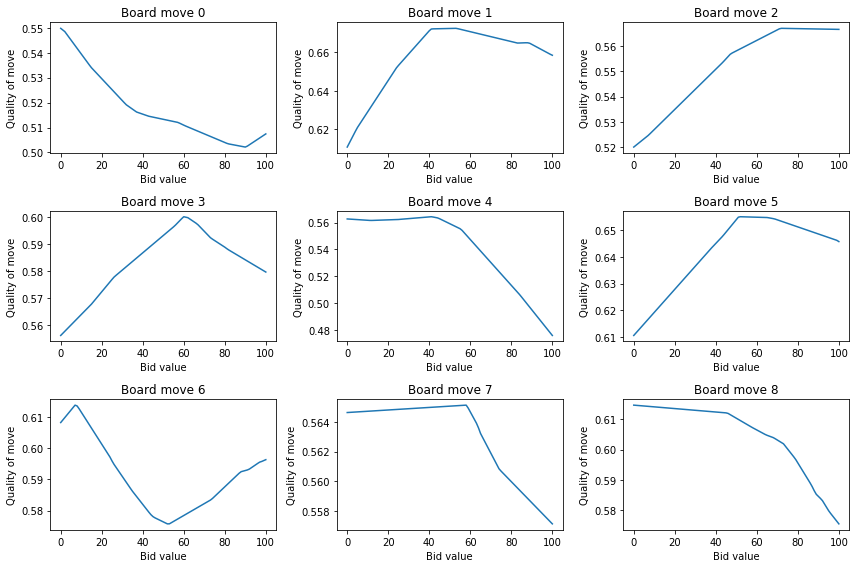

Animation of critic values saved!
Episode #5100  |  Val. Score: +0.40   |  Avg. Val. Score: +0.34  |  Epsilon: 0.682
                  Actor Loss: -1.084  |  Critic Loss: +0.132     |  Time Elapsed: 3343.98s
Episode #5200  |  Val. Score: +0.50   |  Avg. Val. Score: +0.36  |  Epsilon: 0.677
                  Actor Loss: -1.095  |  Critic Loss: +0.151     |  Time Elapsed: 3411.99s
Episode #5300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.36  |  Epsilon: 0.672
                  Actor Loss: -1.104  |  Critic Loss: +0.135     |  Time Elapsed: 3481.69s
Episode #5400  |  Val. Score: +0.00   |  Avg. Val. Score: +0.35  |  Epsilon: 0.667
                  Actor Loss: -1.123  |  Critic Loss: +0.125     |  Time Elapsed: 3546.38s
Episode #5500  |  Val. Score: +0.30   |  Avg. Val. Score: +0.32  |  Epsilon: 0.662
                  Actor Loss: -1.111  |  Critic Loss: +0.151     |  Time Elapsed: 3614.38s
Checkpoint saved!
Episode #5600  |  Val. Score: +0.40   |  Avg. Val. Score: +0.32  |  Epsilon: 0

Episode #9700  |  Val. Score: +0.20   |  Avg. Val. Score: +0.40  |  Epsilon: 0.483
                  Actor Loss: -1.171  |  Critic Loss: +0.149     |  Time Elapsed: 6175.01s
Episode #9800  |  Val. Score: +0.10   |  Avg. Val. Score: +0.31  |  Epsilon: 0.479
                  Actor Loss: -1.117  |  Critic Loss: +0.155     |  Time Elapsed: 6232.26s
Episode #9900  |  Val. Score: +0.10   |  Avg. Val. Score: +0.32  |  Epsilon: 0.476
                  Actor Loss: -1.143  |  Critic Loss: +0.147     |  Time Elapsed: 6289.36s
Episode #10000  |  Val. Score: +0.20   |  Avg. Val. Score: +0.34  |  Epsilon: 0.472
                  Actor Loss: -1.149  |  Critic Loss: +0.148     |  Time Elapsed: 6347.77s
Checkpoint saved!


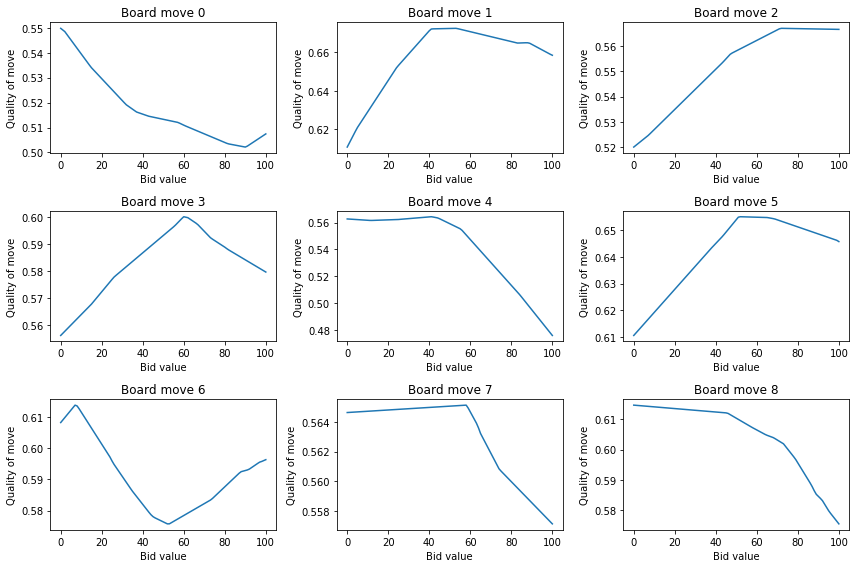

Animation of critic values saved!
Episode #10100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.35  |  Epsilon: 0.469
                  Actor Loss: -1.158  |  Critic Loss: +0.146     |  Time Elapsed: 6412.56s
Episode #10200  |  Val. Score: +0.40   |  Avg. Val. Score: +0.33  |  Epsilon: 0.465
                  Actor Loss: -1.131  |  Critic Loss: +0.152     |  Time Elapsed: 6474.16s
Episode #10300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.35  |  Epsilon: 0.462
                  Actor Loss: -1.123  |  Critic Loss: +0.166     |  Time Elapsed: 6532.59s
Episode #10400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.35  |  Epsilon: 0.458
                  Actor Loss: -1.148  |  Critic Loss: +0.175     |  Time Elapsed: 6592.10s
Episode #10500  |  Val. Score: +0.50   |  Avg. Val. Score: +0.35  |  Epsilon: 0.455
                  Actor Loss: -1.168  |  Critic Loss: +0.152     |  Time Elapsed: 6651.03s
Checkpoint saved!
Episode #10600  |  Val. Score: +0.30   |  Avg. Val. Score: +0.34  |  Epsi

Episode #14700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.67  |  Epsilon: 0.332
                  Actor Loss: -1.134  |  Critic Loss: +0.139     |  Time Elapsed: 8999.90s
Episode #14800  |  Val. Score: +0.50   |  Avg. Val. Score: +0.65  |  Epsilon: 0.330
                  Actor Loss: -1.117  |  Critic Loss: +0.172     |  Time Elapsed: 9054.95s
Episode #14900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.64  |  Epsilon: 0.327
                  Actor Loss: -1.140  |  Critic Loss: +0.148     |  Time Elapsed: 9112.88s
Episode #15000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.67  |  Epsilon: 0.325
                  Actor Loss: -1.118  |  Critic Loss: +0.135     |  Time Elapsed: 9168.70s
Checkpoint saved!


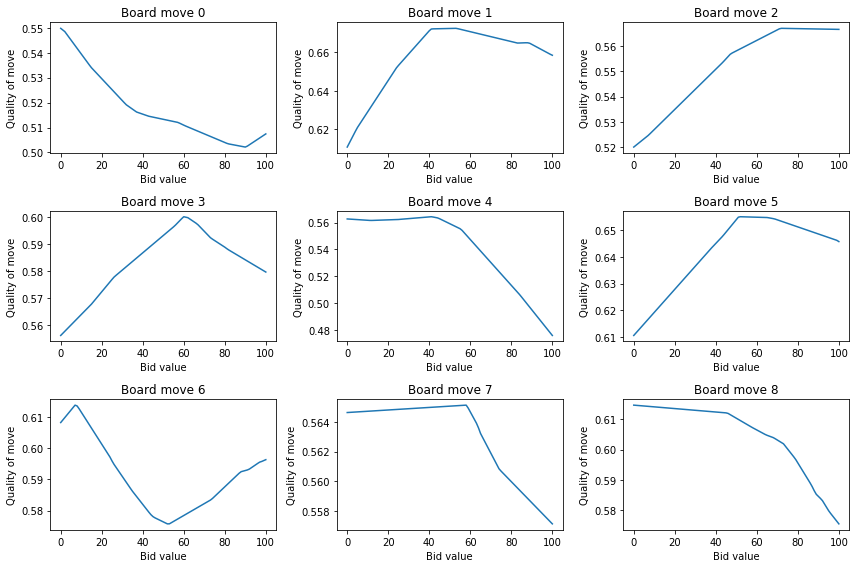

Animation of critic values saved!
Episode #15100  |  Val. Score: +0.30   |  Avg. Val. Score: +0.66  |  Epsilon: 0.322
                  Actor Loss: -1.141  |  Critic Loss: +0.135     |  Time Elapsed: 9230.44s
Episode #15200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.66  |  Epsilon: 0.320
                  Actor Loss: -1.164  |  Critic Loss: +0.123     |  Time Elapsed: 9287.58s
Episode #15300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.68  |  Epsilon: 0.317
                  Actor Loss: -1.133  |  Critic Loss: +0.152     |  Time Elapsed: 9341.86s
Episode #15400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.69  |  Epsilon: 0.315
                  Actor Loss: -1.145  |  Critic Loss: +0.140     |  Time Elapsed: 9399.91s
Episode #15500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.68  |  Epsilon: 0.313
                  Actor Loss: -1.166  |  Critic Loss: +0.120     |  Time Elapsed: 9456.01s
Checkpoint saved!
Episode #15600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.71  |  Epsi

Episode #19700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.72  |  Epsilon: 0.228
                  Actor Loss: -1.093  |  Critic Loss: +0.125     |  Time Elapsed: 11843.41s
Episode #19800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  |  Epsilon: 0.226
                  Actor Loss: -1.132  |  Critic Loss: +0.114     |  Time Elapsed: 11902.46s
Episode #19900  |  Val. Score: +0.50   |  Avg. Val. Score: +0.68  |  Epsilon: 0.225
                  Actor Loss: -1.078  |  Critic Loss: +0.136     |  Time Elapsed: 11959.11s
Episode #20000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.66  |  Epsilon: 0.223
                  Actor Loss: -1.102  |  Critic Loss: +0.132     |  Time Elapsed: 12016.67s
Checkpoint saved!


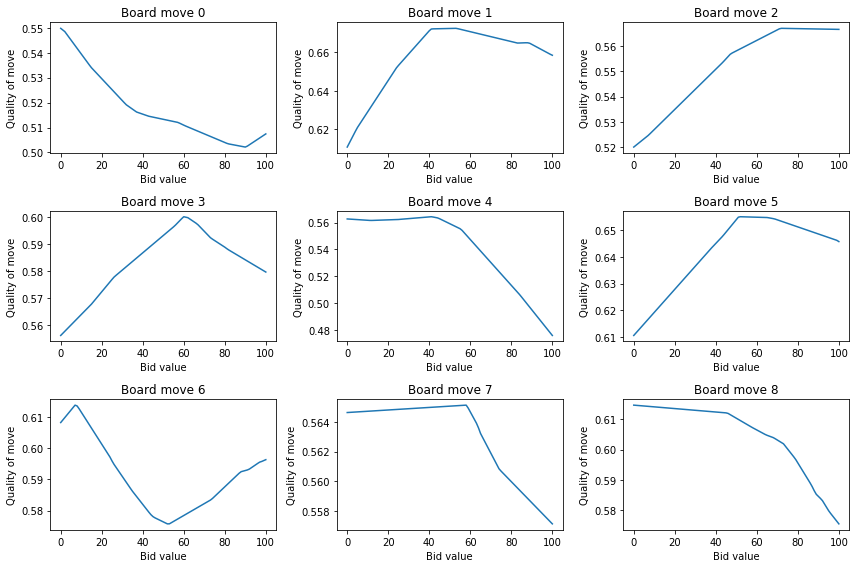

Animation of critic values saved!
Episode #20100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.68  |  Epsilon: 0.221
                  Actor Loss: -1.108  |  Critic Loss: +0.138     |  Time Elapsed: 12082.05s
Episode #20200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.71  |  Epsilon: 0.220
                  Actor Loss: -1.119  |  Critic Loss: +0.102     |  Time Elapsed: 12138.74s
Episode #20300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.75  |  Epsilon: 0.218
                  Actor Loss: -1.101  |  Critic Loss: +0.120     |  Time Elapsed: 12196.29s
Episode #20400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.74  |  Epsilon: 0.217
                  Actor Loss: -1.092  |  Critic Loss: +0.121     |  Time Elapsed: 12252.61s
Episode #20500  |  Val. Score: +0.30   |  Avg. Val. Score: +0.70  |  Epsilon: 0.215
                  Actor Loss: -1.094  |  Critic Loss: +0.118     |  Time Elapsed: 12309.40s
Checkpoint saved!
Episode #20600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.67  | 

Episode #24700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.63  |  Epsilon: 0.157
                  Actor Loss: -1.102  |  Critic Loss: +0.154     |  Time Elapsed: 14736.13s
Episode #24800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.64  |  Epsilon: 0.156
                  Actor Loss: -1.129  |  Critic Loss: +0.145     |  Time Elapsed: 14793.97s
Episode #24900  |  Val. Score: +0.50   |  Avg. Val. Score: +0.61  |  Epsilon: 0.154
                  Actor Loss: -1.106  |  Critic Loss: +0.142     |  Time Elapsed: 14851.90s
Episode #25000  |  Val. Score: +0.50   |  Avg. Val. Score: +0.58  |  Epsilon: 0.153
                  Actor Loss: -1.102  |  Critic Loss: +0.123     |  Time Elapsed: 14910.68s
Checkpoint saved!


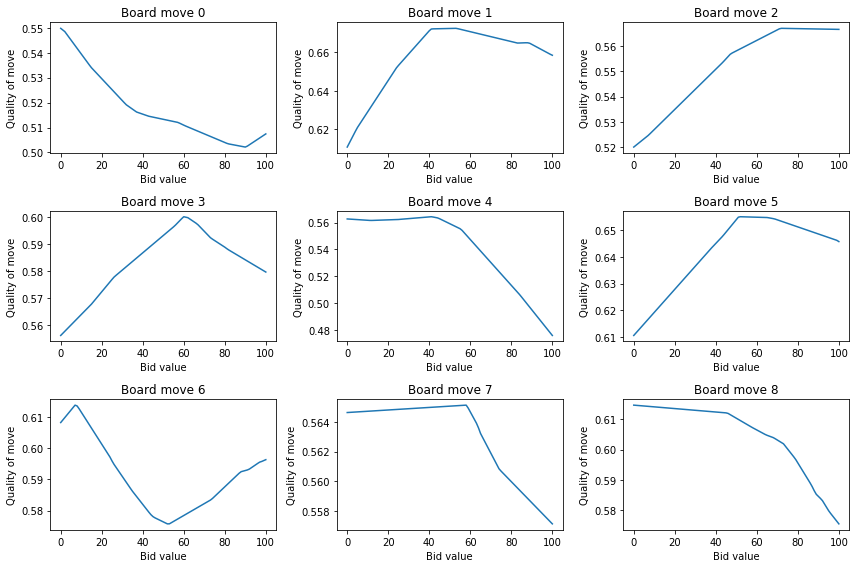

Animation of critic values saved!
Episode #25100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.62  |  Epsilon: 0.152
                  Actor Loss: -1.109  |  Critic Loss: +0.128     |  Time Elapsed: 14979.83s
Episode #25200  |  Val. Score: +0.50   |  Avg. Val. Score: +0.63  |  Epsilon: 0.151
                  Actor Loss: -1.110  |  Critic Loss: +0.146     |  Time Elapsed: 15037.71s
Episode #25300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.63  |  Epsilon: 0.150
                  Actor Loss: -1.134  |  Critic Loss: +0.119     |  Time Elapsed: 15096.61s
Episode #25400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.63  |  Epsilon: 0.149
                  Actor Loss: -1.105  |  Critic Loss: +0.126     |  Time Elapsed: 15153.19s
Episode #25500  |  Val. Score: +0.60   |  Avg. Val. Score: +0.64  |  Epsilon: 0.148
                  Actor Loss: -1.102  |  Critic Loss: +0.134     |  Time Elapsed: 15211.31s
Checkpoint saved!
Episode #25600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.68  | 

Episode #29700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.71  |  Epsilon: 0.108
                  Actor Loss: -1.085  |  Critic Loss: +0.134     |  Time Elapsed: 17655.07s
Episode #29800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.72  |  Epsilon: 0.107
                  Actor Loss: -1.074  |  Critic Loss: +0.103     |  Time Elapsed: 17713.94s
Episode #29900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  |  Epsilon: 0.106
                  Actor Loss: -1.086  |  Critic Loss: +0.129     |  Time Elapsed: 17772.42s
Episode #30000  |  Val. Score: +0.90   |  Avg. Val. Score: +0.73  |  Epsilon: 0.105
                  Actor Loss: -1.089  |  Critic Loss: +0.113     |  Time Elapsed: 17829.95s
Checkpoint saved!


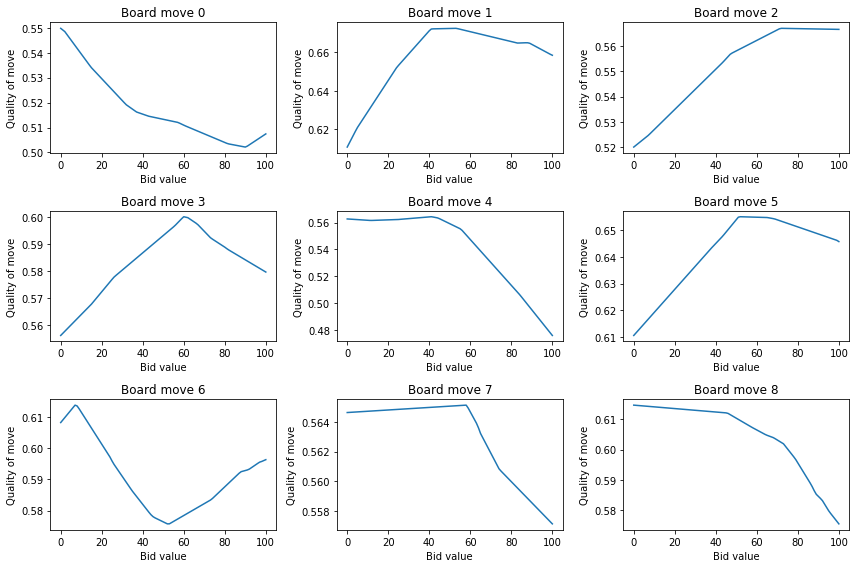

Animation of critic values saved!
Episode #30100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.105
                  Actor Loss: -1.078  |  Critic Loss: +0.111     |  Time Elapsed: 17901.89s
Episode #30200  |  Val. Score: +0.70   |  Avg. Val. Score: +0.70  |  Epsilon: 0.104
                  Actor Loss: -1.112  |  Critic Loss: +0.116     |  Time Elapsed: 17960.92s
Episode #30300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.103
                  Actor Loss: -1.073  |  Critic Loss: +0.126     |  Time Elapsed: 18019.93s
Episode #30400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.72  |  Epsilon: 0.102
                  Actor Loss: -1.042  |  Critic Loss: +0.151     |  Time Elapsed: 18078.38s
Episode #30500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.77  |  Epsilon: 0.102
                  Actor Loss: -1.078  |  Critic Loss: +0.123     |  Time Elapsed: 18136.61s
Checkpoint saved!
Episode #30600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  | 

Episode #34700  |  Val. Score: +0.70   |  Avg. Val. Score: +0.69  |  Epsilon: 0.074
                  Actor Loss: -1.093  |  Critic Loss: +0.109     |  Time Elapsed: 20619.85s
Episode #34800  |  Val. Score: +0.40   |  Avg. Val. Score: +0.65  |  Epsilon: 0.074
                  Actor Loss: -1.092  |  Critic Loss: +0.097     |  Time Elapsed: 20678.63s
Episode #34900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.69  |  Epsilon: 0.073
                  Actor Loss: -1.098  |  Critic Loss: +0.122     |  Time Elapsed: 20736.12s
Episode #35000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.66  |  Epsilon: 0.072
                  Actor Loss: -1.080  |  Critic Loss: +0.122     |  Time Elapsed: 20795.89s
Checkpoint saved!


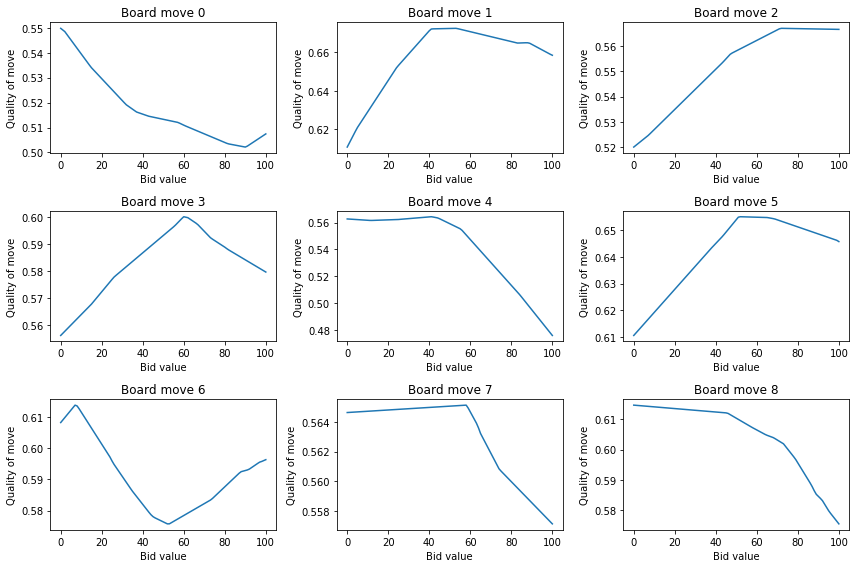

Animation of critic values saved!
Episode #35100  |  Val. Score: +0.20   |  Avg. Val. Score: +0.62  |  Epsilon: 0.072
                  Actor Loss: -1.089  |  Critic Loss: +0.103     |  Time Elapsed: 20869.75s
Episode #35200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.63  |  Epsilon: 0.071
                  Actor Loss: -1.090  |  Critic Loss: +0.116     |  Time Elapsed: 20927.70s
Episode #35300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.62  |  Epsilon: 0.071
                  Actor Loss: -1.083  |  Critic Loss: +0.116     |  Time Elapsed: 20985.54s
Episode #35400  |  Val. Score: +0.10   |  Avg. Val. Score: +0.58  |  Epsilon: 0.070
                  Actor Loss: -1.097  |  Critic Loss: +0.110     |  Time Elapsed: 21047.18s
Episode #35500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.58  |  Epsilon: 0.070
                  Actor Loss: -1.096  |  Critic Loss: +0.119     |  Time Elapsed: 21105.84s
Checkpoint saved!
Episode #35600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.63  | 

Episode #39700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.68  |  Epsilon: 0.051
                  Actor Loss: -1.044  |  Critic Loss: +0.130     |  Time Elapsed: 23592.78s
Episode #39800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.73  |  Epsilon: 0.051
                  Actor Loss: -1.034  |  Critic Loss: +0.115     |  Time Elapsed: 23653.28s
Episode #39900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.72  |  Epsilon: 0.050
                  Actor Loss: -1.062  |  Critic Loss: +0.135     |  Time Elapsed: 23714.75s
Episode #40000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.74  |  Epsilon: 0.050
                  Actor Loss: -1.067  |  Critic Loss: +0.121     |  Time Elapsed: 23774.30s
Checkpoint saved!


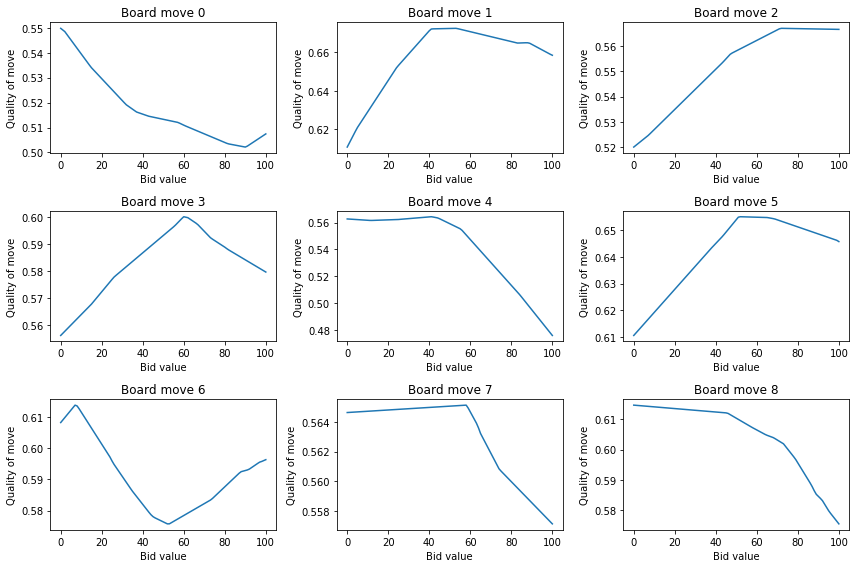

Animation of critic values saved!
Episode #40100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.77  |  Epsilon: 0.049
                  Actor Loss: -1.061  |  Critic Loss: +0.122     |  Time Elapsed: 23850.75s
Episode #40200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.049
                  Actor Loss: -1.088  |  Critic Loss: +0.111     |  Time Elapsed: 23909.71s
Episode #40300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  |  Epsilon: 0.049
                  Actor Loss: -1.060  |  Critic Loss: +0.115     |  Time Elapsed: 23968.56s
Episode #40400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.75  |  Epsilon: 0.048
                  Actor Loss: -1.071  |  Critic Loss: +0.118     |  Time Elapsed: 24026.66s
Episode #40500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.048
                  Actor Loss: -1.074  |  Critic Loss: +0.107     |  Time Elapsed: 24084.79s
Checkpoint saved!
Episode #40600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.75  | 

Episode #44700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.035
                  Actor Loss: -1.012  |  Critic Loss: +0.120     |  Time Elapsed: 26612.14s
Episode #44800  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.035
                  Actor Loss: -1.035  |  Critic Loss: +0.113     |  Time Elapsed: 26673.94s
Episode #44900  |  Val. Score: +0.60   |  Avg. Val. Score: +0.80  |  Epsilon: 0.034
                  Actor Loss: -1.051  |  Critic Loss: +0.118     |  Time Elapsed: 26735.40s
Episode #45000  |  Val. Score: +0.60   |  Avg. Val. Score: +0.76  |  Epsilon: 0.034
                  Actor Loss: -1.048  |  Critic Loss: +0.115     |  Time Elapsed: 26796.14s
Checkpoint saved!


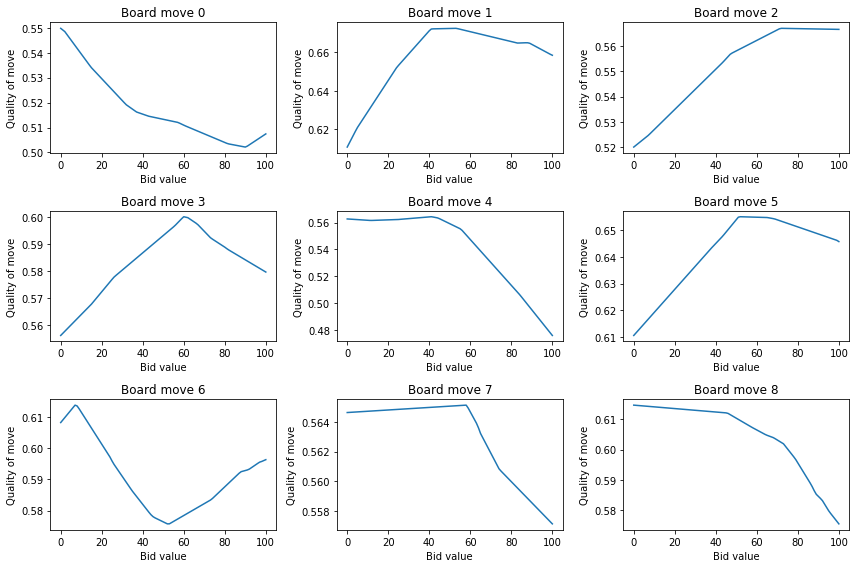

Animation of critic values saved!
Episode #45100  |  Val. Score: +0.60   |  Avg. Val. Score: +0.74  |  Epsilon: 0.034
                  Actor Loss: -1.030  |  Critic Loss: +0.112     |  Time Elapsed: 26875.13s
Episode #45200  |  Val. Score: +0.90   |  Avg. Val. Score: +0.77  |  Epsilon: 0.034
                  Actor Loss: -1.049  |  Critic Loss: +0.108     |  Time Elapsed: 26934.71s
Episode #45300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.033
                  Actor Loss: -1.036  |  Critic Loss: +0.112     |  Time Elapsed: 26996.40s
Episode #45400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.76  |  Epsilon: 0.033
                  Actor Loss: -1.046  |  Critic Loss: +0.099     |  Time Elapsed: 27057.76s
Episode #45500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.71  |  Epsilon: 0.033
                  Actor Loss: -1.040  |  Critic Loss: +0.122     |  Time Elapsed: 27119.17s
Checkpoint saved!
Episode #45600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.69  | 

Episode #49700  |  Val. Score: +0.50   |  Avg. Val. Score: +0.75  |  Epsilon: 0.024
                  Actor Loss: -0.940  |  Critic Loss: +0.108     |  Time Elapsed: 29705.01s
Episode #49800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.024
                  Actor Loss: -0.992  |  Critic Loss: +0.107     |  Time Elapsed: 29766.38s
Episode #49900  |  Val. Score: +0.50   |  Avg. Val. Score: +0.74  |  Epsilon: 0.024
                  Actor Loss: -0.963  |  Critic Loss: +0.109     |  Time Elapsed: 29827.12s
Episode #50000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.71  |  Epsilon: 0.024
                  Actor Loss: -1.003  |  Critic Loss: +0.103     |  Time Elapsed: 29890.80s
Checkpoint saved!


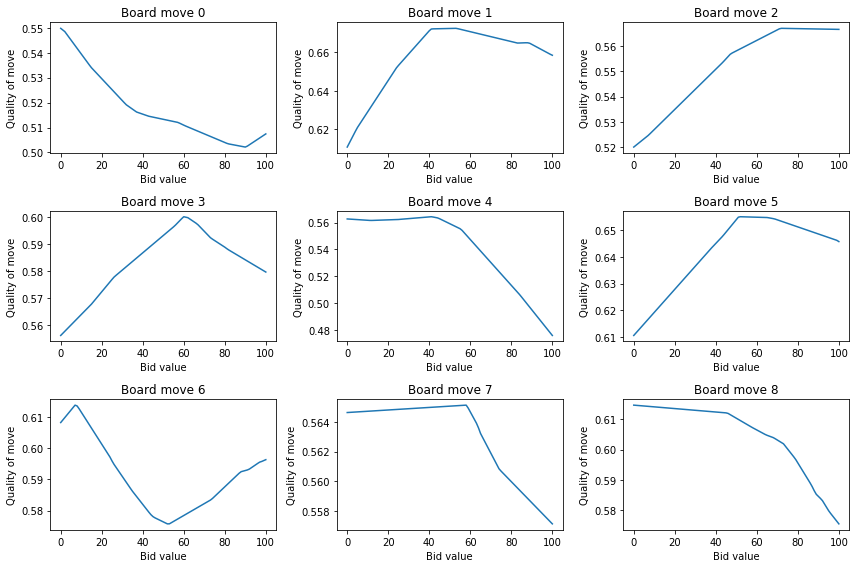

Animation of critic values saved!
Episode #50100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.72  |  Epsilon: 0.023
                  Actor Loss: -0.979  |  Critic Loss: +0.095     |  Time Elapsed: 29975.42s
Episode #50200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.73  |  Epsilon: 0.023
                  Actor Loss: -0.979  |  Critic Loss: +0.097     |  Time Elapsed: 30038.97s
Episode #50300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.73  |  Epsilon: 0.023
                  Actor Loss: -0.946  |  Critic Loss: +0.117     |  Time Elapsed: 30100.33s
Episode #50400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.71  |  Epsilon: 0.023
                  Actor Loss: -0.980  |  Critic Loss: +0.113     |  Time Elapsed: 30164.01s
Episode #50500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.68  |  Epsilon: 0.023
                  Actor Loss: -0.961  |  Critic Loss: +0.093     |  Time Elapsed: 30228.02s
Checkpoint saved!
Episode #50600  |  Val. Score: +0.50   |  Avg. Val. Score: +0.71  | 

Episode #54700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.74  |  Epsilon: 0.017
                  Actor Loss: -0.975  |  Critic Loss: +0.090     |  Time Elapsed: 32875.98s
Episode #54800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.77  |  Epsilon: 0.016
                  Actor Loss: -0.969  |  Critic Loss: +0.120     |  Time Elapsed: 32941.15s
Episode #54900  |  Val. Score: +0.70   |  Avg. Val. Score: +0.76  |  Epsilon: 0.016
                  Actor Loss: -0.969  |  Critic Loss: +0.084     |  Time Elapsed: 33007.92s
Episode #55000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  |  Epsilon: 0.016
                  Actor Loss: -0.976  |  Critic Loss: +0.115     |  Time Elapsed: 33072.30s
Checkpoint saved!


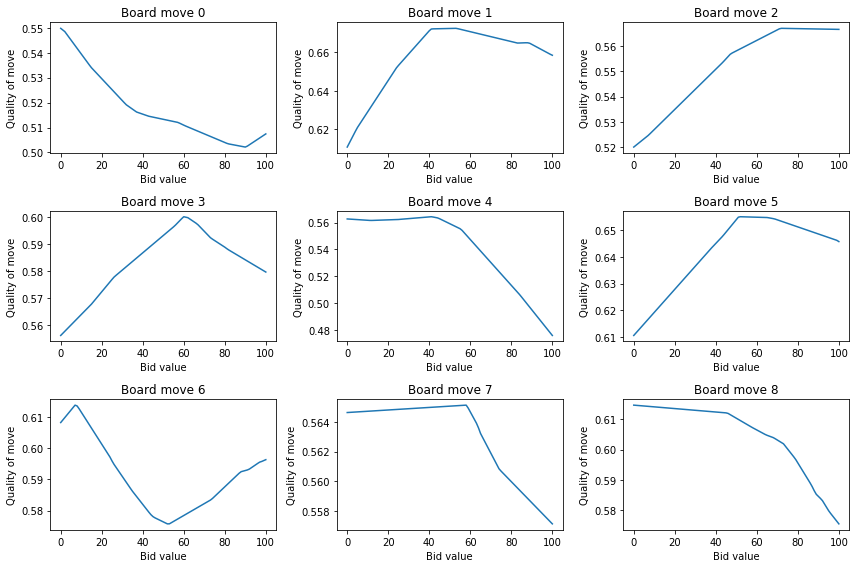

Animation of critic values saved!
Episode #55100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.79  |  Epsilon: 0.016
                  Actor Loss: -0.962  |  Critic Loss: +0.090     |  Time Elapsed: 33161.02s
Episode #55200  |  Val. Score: +0.50   |  Avg. Val. Score: +0.76  |  Epsilon: 0.016
                  Actor Loss: -0.959  |  Critic Loss: +0.098     |  Time Elapsed: 33226.06s
Episode #55300  |  Val. Score: +0.70   |  Avg. Val. Score: +0.74  |  Epsilon: 0.016
                  Actor Loss: -0.987  |  Critic Loss: +0.077     |  Time Elapsed: 33291.53s
Episode #55400  |  Val. Score: +0.40   |  Avg. Val. Score: +0.72  |  Epsilon: 0.016
                  Actor Loss: -0.965  |  Critic Loss: +0.109     |  Time Elapsed: 33356.33s
Episode #55500  |  Val. Score: +0.40   |  Avg. Val. Score: +0.68  |  Epsilon: 0.016
                  Actor Loss: -0.962  |  Critic Loss: +0.105     |  Time Elapsed: 33421.10s
Checkpoint saved!
Episode #55600  |  Val. Score: +0.60   |  Avg. Val. Score: +0.66  | 

Episode #59700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.011
                  Actor Loss: -0.933  |  Critic Loss: +0.089     |  Time Elapsed: 36171.93s
Episode #59800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.011
                  Actor Loss: -0.937  |  Critic Loss: +0.091     |  Time Elapsed: 36237.25s
Episode #59900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  |  Epsilon: 0.011
                  Actor Loss: -0.910  |  Critic Loss: +0.098     |  Time Elapsed: 36303.98s
Episode #60000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.81  |  Epsilon: 0.011
                  Actor Loss: -0.916  |  Critic Loss: +0.098     |  Time Elapsed: 36368.74s
Checkpoint saved!


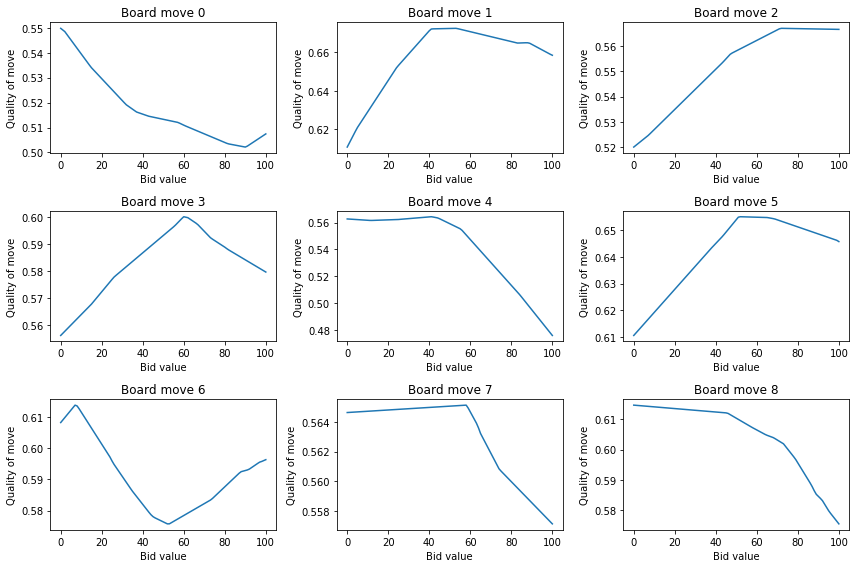

Animation of critic values saved!
Episode #60100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.80  |  Epsilon: 0.011
                  Actor Loss: -0.919  |  Critic Loss: +0.090     |  Time Elapsed: 36458.17s
Episode #60200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.82  |  Epsilon: 0.011
                  Actor Loss: -0.919  |  Critic Loss: +0.081     |  Time Elapsed: 36524.29s
Episode #60300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.011
                  Actor Loss: -0.908  |  Critic Loss: +0.086     |  Time Elapsed: 36590.10s
Episode #60400  |  Val. Score: +0.60   |  Avg. Val. Score: +0.86  |  Epsilon: 0.011
                  Actor Loss: -0.912  |  Critic Loss: +0.082     |  Time Elapsed: 36653.03s
Episode #60500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.85  |  Epsilon: 0.011
                  Actor Loss: -0.941  |  Critic Loss: +0.096     |  Time Elapsed: 36719.73s
Checkpoint saved!
Episode #60600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.84  | 

Episode #64700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.952  |  Critic Loss: +0.093     |  Time Elapsed: 39535.71s
Episode #64800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.919  |  Critic Loss: +0.103     |  Time Elapsed: 39604.92s
Episode #64900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.984  |  Critic Loss: +0.096     |  Time Elapsed: 39671.69s
Episode #65000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.967  |  Critic Loss: +0.087     |  Time Elapsed: 39740.48s
Checkpoint saved!


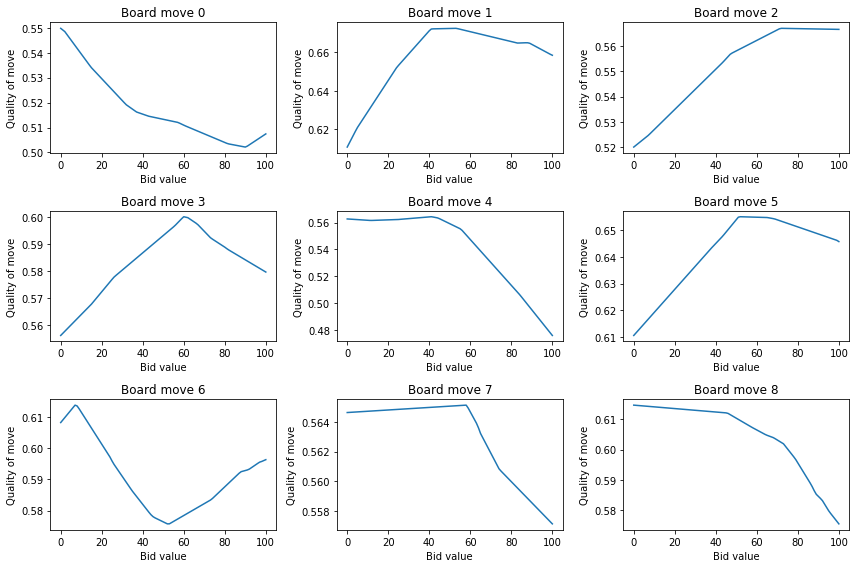

Animation of critic values saved!
Episode #65100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.92  |  Epsilon: 0.010
                  Actor Loss: -0.949  |  Critic Loss: +0.082     |  Time Elapsed: 39838.59s
Episode #65200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.967  |  Critic Loss: +0.102     |  Time Elapsed: 39904.66s
Episode #65300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.992  |  Critic Loss: +0.087     |  Time Elapsed: 39972.55s
Episode #65400  |  Val. Score: +0.90   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.971  |  Critic Loss: +0.092     |  Time Elapsed: 40040.24s
Episode #65500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.956  |  Critic Loss: +0.111     |  Time Elapsed: 40108.85s
Checkpoint saved!
Episode #65600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  | 

Episode #69700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -0.939  |  Critic Loss: +0.096     |  Time Elapsed: 42968.95s
Episode #69800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.74  |  Epsilon: 0.010
                  Actor Loss: -0.962  |  Critic Loss: +0.080     |  Time Elapsed: 43037.33s
Episode #69900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.73  |  Epsilon: 0.010
                  Actor Loss: -0.952  |  Critic Loss: +0.078     |  Time Elapsed: 43109.20s
Episode #70000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.929  |  Critic Loss: +0.100     |  Time Elapsed: 43176.71s
Checkpoint saved!


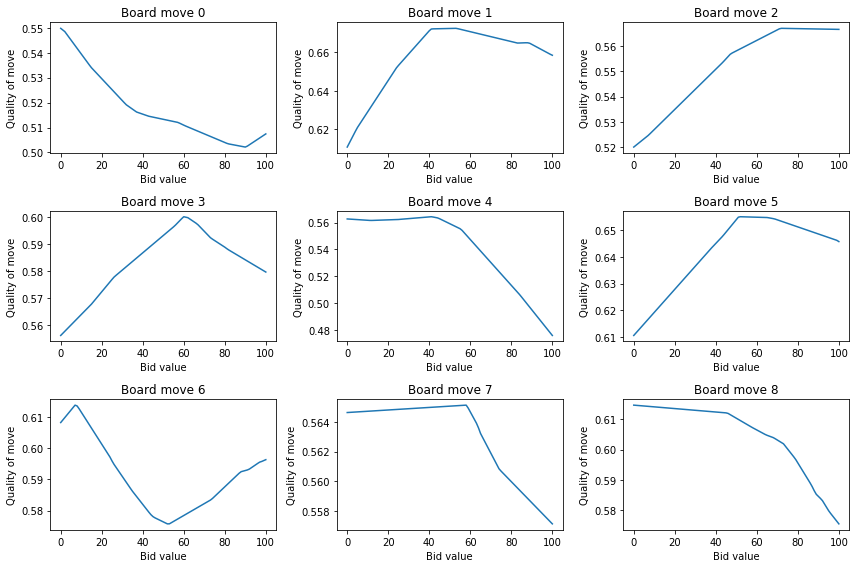

Animation of critic values saved!
Episode #70100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.80  |  Epsilon: 0.010
                  Actor Loss: -0.935  |  Critic Loss: +0.104     |  Time Elapsed: 43277.10s
Episode #70200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.945  |  Critic Loss: +0.093     |  Time Elapsed: 43345.63s
Episode #70300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.973  |  Critic Loss: +0.088     |  Time Elapsed: 43416.53s
Episode #70400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.934  |  Critic Loss: +0.094     |  Time Elapsed: 43483.96s
Episode #70500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.957  |  Critic Loss: +0.091     |  Time Elapsed: 43553.02s
Checkpoint saved!
Episode #70600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  | 

Episode #74700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.981  |  Critic Loss: +0.111     |  Time Elapsed: 46540.85s
Episode #74800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.993  |  Critic Loss: +0.094     |  Time Elapsed: 46613.48s
Episode #74900  |  Val. Score: +1.00   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -1.005  |  Critic Loss: +0.106     |  Time Elapsed: 46685.10s
Episode #75000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.987  |  Critic Loss: +0.087     |  Time Elapsed: 46759.65s
Checkpoint saved!


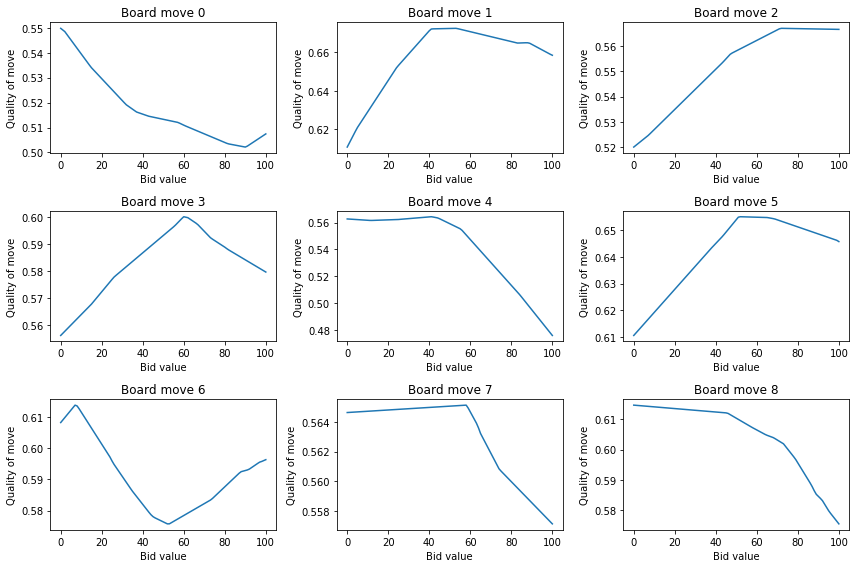

Animation of critic values saved!
Episode #75100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.985  |  Critic Loss: +0.108     |  Time Elapsed: 46863.12s
Episode #75200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.977  |  Critic Loss: +0.092     |  Time Elapsed: 46934.77s
Episode #75300  |  Val. Score: +0.90   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.973  |  Critic Loss: +0.105     |  Time Elapsed: 47002.58s
Episode #75400  |  Val. Score: +0.70   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.978  |  Critic Loss: +0.102     |  Time Elapsed: 47075.01s
Episode #75500  |  Val. Score: +0.70   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.978  |  Critic Loss: +0.108     |  Time Elapsed: 47145.71s
Checkpoint saved!
Episode #75600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.87  | 

Episode #79700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.75  |  Epsilon: 0.010
                  Actor Loss: -0.953  |  Critic Loss: +0.116     |  Time Elapsed: 50186.64s
Episode #79800  |  Val. Score: +0.90   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.943  |  Critic Loss: +0.104     |  Time Elapsed: 50262.56s
Episode #79900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.976  |  Critic Loss: +0.088     |  Time Elapsed: 50336.65s
Episode #80000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.918  |  Critic Loss: +0.087     |  Time Elapsed: 50408.22s
Checkpoint saved!


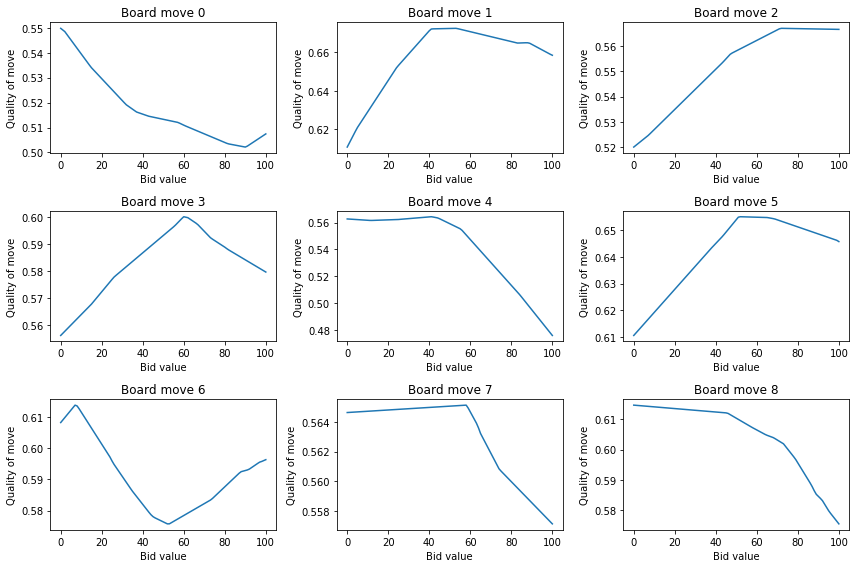

Animation of critic values saved!
Episode #80100  |  Val. Score: +0.90   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.931  |  Critic Loss: +0.093     |  Time Elapsed: 50518.19s
Episode #80200  |  Val. Score: +0.80   |  Avg. Val. Score: +0.78  |  Epsilon: 0.010
                  Actor Loss: -0.971  |  Critic Loss: +0.102     |  Time Elapsed: 50592.86s
Episode #80300  |  Val. Score: +0.40   |  Avg. Val. Score: +0.77  |  Epsilon: 0.010
                  Actor Loss: -0.942  |  Critic Loss: +0.082     |  Time Elapsed: 50666.58s
Episode #80400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.941  |  Critic Loss: +0.089     |  Time Elapsed: 50740.88s
Episode #80500  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.937  |  Critic Loss: +0.087     |  Time Elapsed: 50816.29s
Checkpoint saved!
Episode #80600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.83  | 

Episode #84700  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.934  |  Critic Loss: +0.092     |  Time Elapsed: 53980.89s
Episode #84800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.948  |  Critic Loss: +0.080     |  Time Elapsed: 54059.87s
Episode #84900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.931  |  Critic Loss: +0.111     |  Time Elapsed: 54134.79s
Episode #85000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.907  |  Critic Loss: +0.077     |  Time Elapsed: 54212.34s
Checkpoint saved!


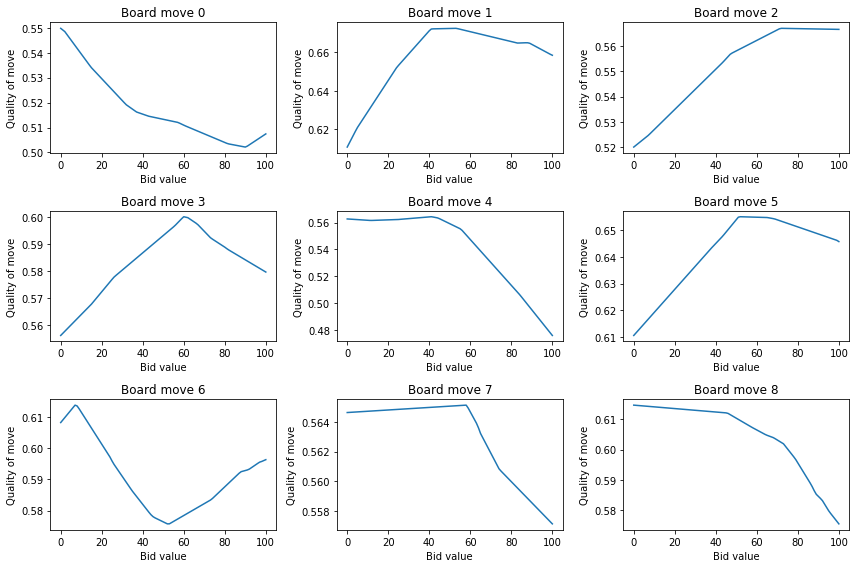

Animation of critic values saved!
Episode #85100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.928  |  Critic Loss: +0.095     |  Time Elapsed: 54325.92s
Episode #85200  |  Val. Score: +0.60   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.945  |  Critic Loss: +0.083     |  Time Elapsed: 54403.85s
Episode #85300  |  Val. Score: +0.60   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.974  |  Critic Loss: +0.088     |  Time Elapsed: 54481.20s
Episode #85400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.931  |  Critic Loss: +0.091     |  Time Elapsed: 54558.43s
Episode #85500  |  Val. Score: +0.90   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.958  |  Critic Loss: +0.106     |  Time Elapsed: 54635.92s
Checkpoint saved!
Episode #85600  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  | 

Episode #89700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.936  |  Critic Loss: +0.097     |  Time Elapsed: 57945.07s
Episode #89800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.935  |  Critic Loss: +0.088     |  Time Elapsed: 58024.12s
Episode #89900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.908  |  Critic Loss: +0.081     |  Time Elapsed: 58104.58s
Episode #90000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.90  |  Epsilon: 0.010
                  Actor Loss: -0.967  |  Critic Loss: +0.094     |  Time Elapsed: 58184.34s
Checkpoint saved!


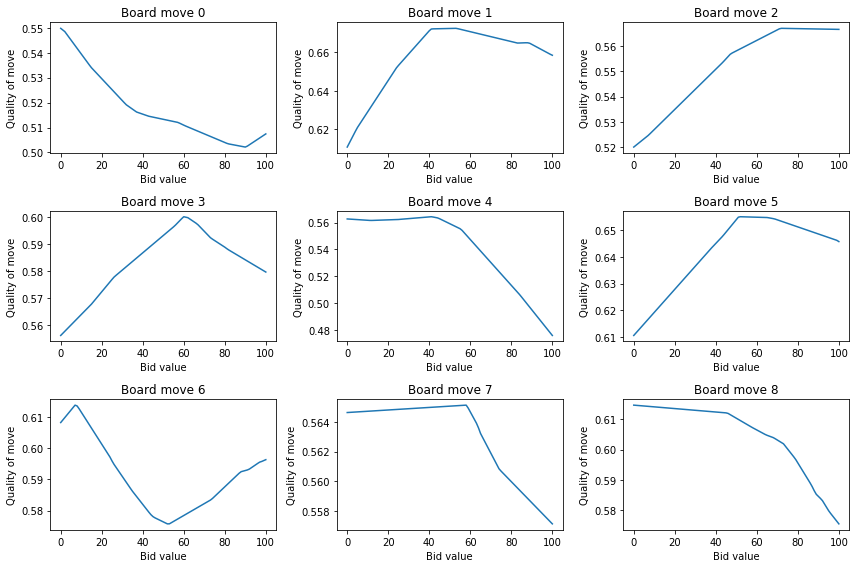

Animation of critic values saved!
Episode #90100  |  Val. Score: +0.70   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.914  |  Critic Loss: +0.093     |  Time Elapsed: 58303.12s
Episode #90200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.91  |  Epsilon: 0.010
                  Actor Loss: -0.895  |  Critic Loss: +0.088     |  Time Elapsed: 58383.92s
Episode #90300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.903  |  Critic Loss: +0.097     |  Time Elapsed: 58463.74s
Episode #90400  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.924  |  Critic Loss: +0.091     |  Time Elapsed: 58543.12s
Episode #90500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.916  |  Critic Loss: +0.081     |  Time Elapsed: 58624.19s
Checkpoint saved!
Episode #90600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.87  | 

Episode #94700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.940  |  Critic Loss: +0.095     |  Time Elapsed: 62036.70s
Episode #94800  |  Val. Score: +0.90   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.933  |  Critic Loss: +0.089     |  Time Elapsed: 62117.91s
Episode #94900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.937  |  Critic Loss: +0.078     |  Time Elapsed: 62199.07s
Episode #95000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.936  |  Critic Loss: +0.079     |  Time Elapsed: 62282.20s
Checkpoint saved!


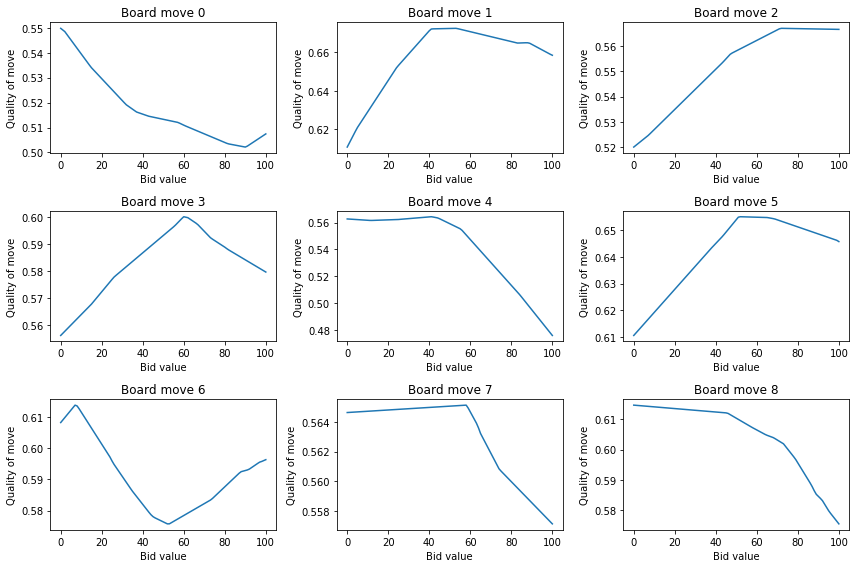

Animation of critic values saved!
Episode #95100  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.950  |  Critic Loss: +0.083     |  Time Elapsed: 62405.73s
Episode #95200  |  Val. Score: +0.40   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.921  |  Critic Loss: +0.081     |  Time Elapsed: 62487.53s
Episode #95300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.912  |  Critic Loss: +0.072     |  Time Elapsed: 62570.07s
Episode #95400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.81  |  Epsilon: 0.010
                  Actor Loss: -0.931  |  Critic Loss: +0.080     |  Time Elapsed: 62653.28s
Episode #95500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.904  |  Critic Loss: +0.082     |  Time Elapsed: 62736.36s
Checkpoint saved!
Episode #95600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.81  | 

Episode #99700  |  Val. Score: +0.60   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.900  |  Critic Loss: +0.079     |  Time Elapsed: 66279.12s
Episode #99800  |  Val. Score: +1.00   |  Avg. Val. Score: +0.89  |  Epsilon: 0.010
                  Actor Loss: -0.900  |  Critic Loss: +0.075     |  Time Elapsed: 66363.03s
Episode #99900  |  Val. Score: +0.90   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.874  |  Critic Loss: +0.085     |  Time Elapsed: 66449.08s
Episode #100000  |  Val. Score: +0.80   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.892  |  Critic Loss: +0.081     |  Time Elapsed: 66533.70s
Checkpoint saved!


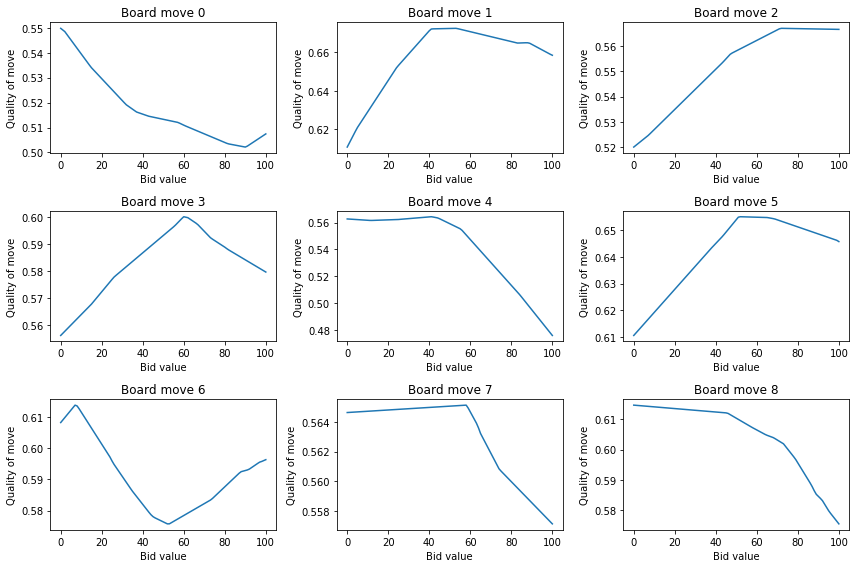

Animation of critic values saved!
Model saved!


In [11]:
n_episodes=100000
checkpoint_each=500
validate_each=100
n_episodes_validation=10
save_critic_value_each=1000
save_animation_each=5000
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999925
players = [
    DRLPlayer(0, controller.game, drl_agent, train_mode=True),
]
if TRAIN_MODE == 'self_play':
    players.append(DRLPlayer(1, controller.game, drl_agent, train_mode=True))
else:
    players.append(RandomPlayer(1))
validation_scores, critic_values_by_episode = init_train(controller, players, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=n_episodes, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


In [12]:
len(critic_values_by_episode)

100

In [13]:
final_validation_scores = validation_scores
final_critic_values_by_episode = critic_values_by_episode

Episode #114600  |  Val. Score: +1.00   |  Avg. Val. Score: +1.00  |  Epsilon: 0.010
                  Actor Loss: -0.876  |  Critic Loss: +0.083     |  Time Elapsed: 84.82s
Episode #114700  |  Val. Score: +0.90   |  Avg. Val. Score: +0.95  |  Epsilon: 0.010
                  Actor Loss: -0.878  |  Critic Loss: +0.082     |  Time Elapsed: 171.31s
Episode #114800  |  Val. Score: +0.70   |  Avg. Val. Score: +0.87  |  Epsilon: 0.010
                  Actor Loss: -0.887  |  Critic Loss: +0.080     |  Time Elapsed: 258.18s
Episode #114900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.869  |  Critic Loss: +0.074     |  Time Elapsed: 345.82s
Episode #115000  |  Val. Score: +1.00   |  Avg. Val. Score: +0.88  |  Epsilon: 0.010
                  Actor Loss: -0.885  |  Critic Loss: +0.081     |  Time Elapsed: 436.82s
Checkpoint saved!


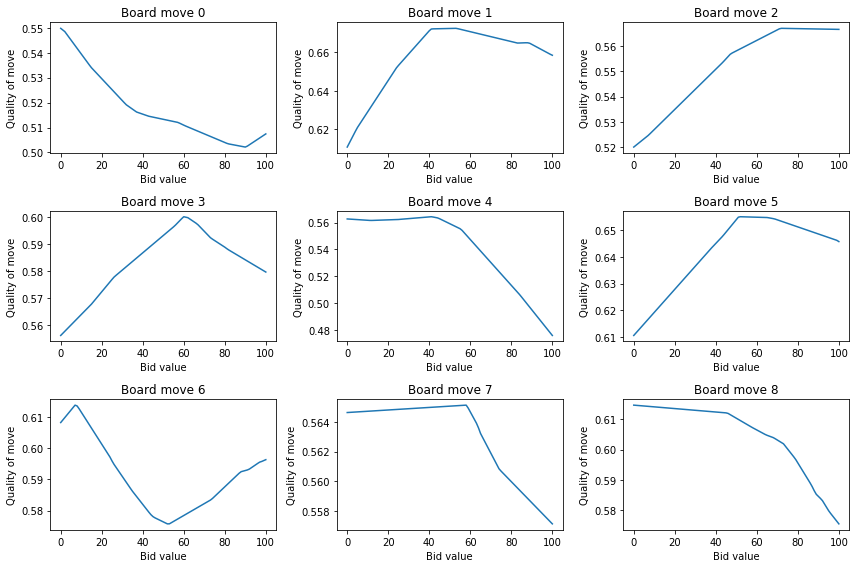

Animation of critic values saved!
Episode #115100  |  Val. Score: +0.50   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.872  |  Critic Loss: +0.089     |  Time Elapsed: 630.22s
Episode #115200  |  Val. Score: +1.00   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.868  |  Critic Loss: +0.076     |  Time Elapsed: 724.23s
Episode #115300  |  Val. Score: +0.80   |  Avg. Val. Score: +0.84  |  Epsilon: 0.010
                  Actor Loss: -0.857  |  Critic Loss: +0.096     |  Time Elapsed: 812.26s
Episode #115400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.86  |  Epsilon: 0.010
                  Actor Loss: -0.903  |  Critic Loss: +0.084     |  Time Elapsed: 902.03s
Episode #115500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.873  |  Critic Loss: +0.090     |  Time Elapsed: 994.54s
Checkpoint saved!
Episode #115600  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Eps

Episode #119700  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.896  |  Critic Loss: +0.099     |  Time Elapsed: 5056.88s
Episode #119800  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.895  |  Critic Loss: +0.074     |  Time Elapsed: 5161.82s
Episode #119900  |  Val. Score: +0.80   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.922  |  Critic Loss: +0.070     |  Time Elapsed: 5271.46s
Episode #120000  |  Val. Score: +0.70   |  Avg. Val. Score: +0.80  |  Epsilon: 0.010
                  Actor Loss: -0.915  |  Critic Loss: +0.091     |  Time Elapsed: 5377.66s
Checkpoint saved!


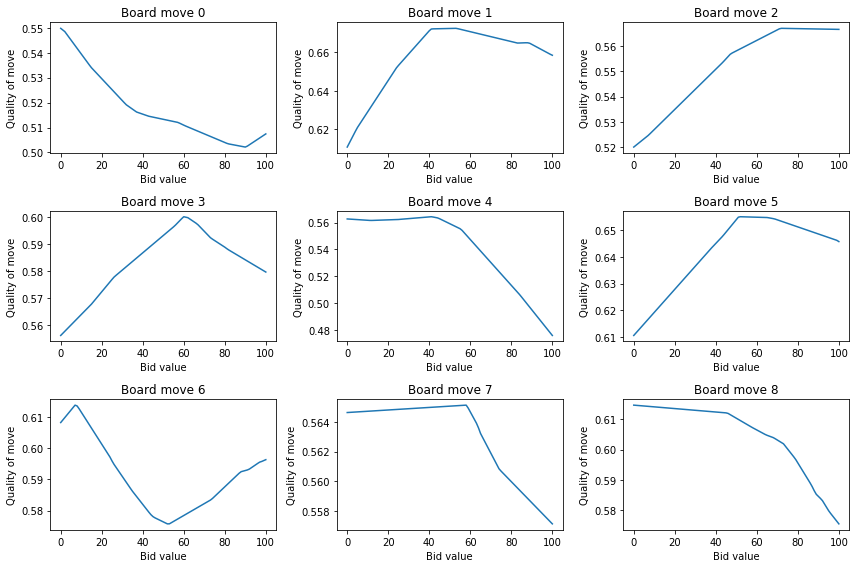

Animation of critic values saved!
Episode #120100  |  Val. Score: +0.80   |  Avg. Val. Score: +0.79  |  Epsilon: 0.010
                  Actor Loss: -0.897  |  Critic Loss: +0.085     |  Time Elapsed: 5601.64s
Episode #120200  |  Val. Score: +0.90   |  Avg. Val. Score: +0.82  |  Epsilon: 0.010
                  Actor Loss: -0.917  |  Critic Loss: +0.077     |  Time Elapsed: 5706.08s
Episode #120300  |  Val. Score: +1.00   |  Avg. Val. Score: +0.83  |  Epsilon: 0.010
                  Actor Loss: -0.920  |  Critic Loss: +0.067     |  Time Elapsed: 5814.25s
Episode #120400  |  Val. Score: +1.00   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.911  |  Critic Loss: +0.082     |  Time Elapsed: 5923.50s
Episode #120500  |  Val. Score: +0.80   |  Avg. Val. Score: +0.85  |  Epsilon: 0.010
                  Actor Loss: -0.914  |  Critic Loss: +0.103     |  Time Elapsed: 6034.00s
Checkpoint saved!
Episode #120600  |  Val. Score: +0.90   |  Avg. Val. Score: +0.85  |

In [21]:
# Continue training
validation_scores_continued, critic_values_by_episode_continued = init_train(controller, players,
                    start_epoch=114501, critic_values_by_episode=critic_values_by_episode, model_path=f'../checkpoints/{MODEL_VERSION}_model.pt',
                    n_episodes=10000, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=0.01, eps_end=eps_end, eps_decay=eps_decay)

In [22]:
final_validation_scores += validation_scores_continued
final_critic_values_by_episode += critic_values_by_episode_continued

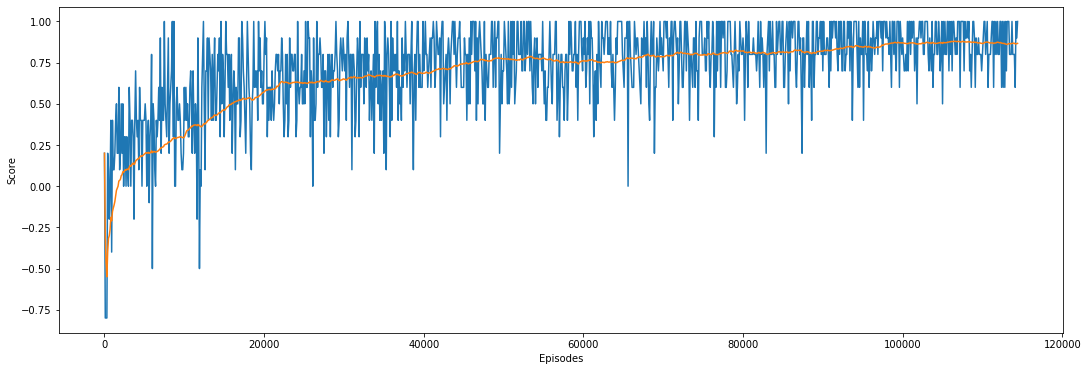

In [23]:
plot_scores(final_validation_scores, validate_each)

In [17]:
drl_agent.save_model(f'../checkpoints/{MODEL_VERSION}_model_final.pt')

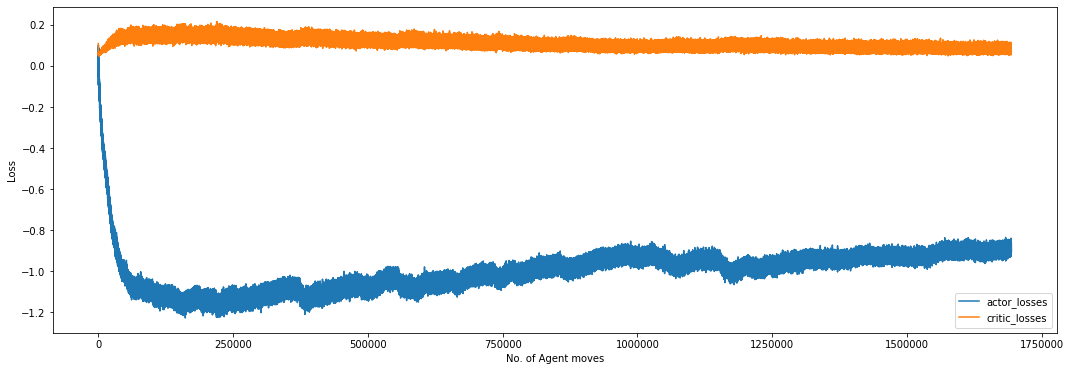

In [18]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [19]:
controller.reset_game(drl_checkpoint_path=f'../checkpoints/{MODEL_VERSION}_model.pt')

Select one of the following players to be player 1
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 0
player_class.__name__ = DRLPlayer
player_kwargs['initial_checkpoint_path'] = drl_checkpoint_path = ../checkpoints/v7_model.pt
initial_checkpoint_path: ../checkpoints/v7_model.pt
Select one of the following players to be player 2
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 1
player_class.__name__ = HumanPlayer
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X): 100           Player 2 (O): 100

Player 1 DRLPlayer(X) bidding...
Player 2 HumanPlayer(O) bidding...
20
Player 1 DRLPlayer(X) bid: 22  |  Player 2 HumanPlayer(O) bid: 20  |  
Player 1 DRLPlayer(X) won the bet
                  1 | 2 | 3 
     

In [20]:
run_validation(players, 1000)

0.85